Exercise 2: Video processing
=======================

To complete the exercise, follow the instructions and complete the missing code and write the answers where required.  All points, except the ones marked with **(N points)** are mandatory. The optional tasks require more independet work and some extra effort. Without completing them you can get at most 75 points for the exercise (the total number of points is 100 and results in grade 10). Sometimes there are more optional exercises and you do not have to complete all of them, you can get at most 100 points.

In [1]:
%matplotlib notebook

# First, tun this cell to download the data used in this exercise
import zipfile, urllib.request, io
zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("http://data.vicos.si/lukacu/multimedia/Exercise2.zip").read())).extractall()

**Note about video visualization:** Videos cannot be visualized directly in Jupyter, you have to render them to a file and then link a file which is loaded by the browser and visualized. Most browsers can play MP4 files, so that should be your format of choice.

In [2]:
from IPython.display import Video
Video("shaky.mp4")

Assignment 1: Video stabilization
--------

Video stabilization is the process of estimating the motion between consecutive frames, and applying an image transformation that either cancels out the motion or diminishes its effects. It is important to note that video stabilization reduces the effective image size, so one should not consider it to be a substitution for a proper video capture procedure.

The goal of this assignment will be the compensation of translational vibrations, which cause a video frame from time t to be shifted according to vector v $t = (x_t , y_t )$. The underlying idea is as follows:

 1. First, you need to select a stable point in the image, preferably one that can be tracked throughout the whole length of the video.
 2. Having chosen the point to track, you need to estimate its motion trajectory throughout the video, relative to its position in the first frame.
 3. Compensate for motion in each frame by translating the image by the negative value of estimated relative position of the tracked point, and gather the translated frames in new, stabilized, video.
 
The tracking of the selected point can be achieved by using the *normalized cross-corelation* (NCC) method. Using this method, you will compare the patch around the selected point with patches in the subsequent images, and find the best match. The normalized cross-correlation between the *template patch* and a given *image patch* is computed using the following formula:

\begin{equation}
\frac{1}{n} \sum_{x,y}\frac{(f(x,y) - \overline{f})(t(x,y) - \overline{t})}{\sigma_f \sigma_t},
\end{equation}

where $t(x,y)$ denotes the template, and $f(x,y)$ denotes the image patch that we are comparing to the template. $n$ denotes the number of pixels in the patch (both template and image patch are of same dimensions); $\overline{f}$ and $\overline{t}$ denote the mean, while $\sigma_f$ and $\sigma_t$ denote the standard deviation of the image and the template patch, respectively. This way one can determine the position of the template inside a larger image by computing the *similarity scores* between the template and all patches inside the image.




 * Read the `shaky.mp4` video using `skvideo.io.vread` and display several frames from the in-memory 4D representation.


(348, 240, 426, 3)


<IPython.core.display.Javascript object>


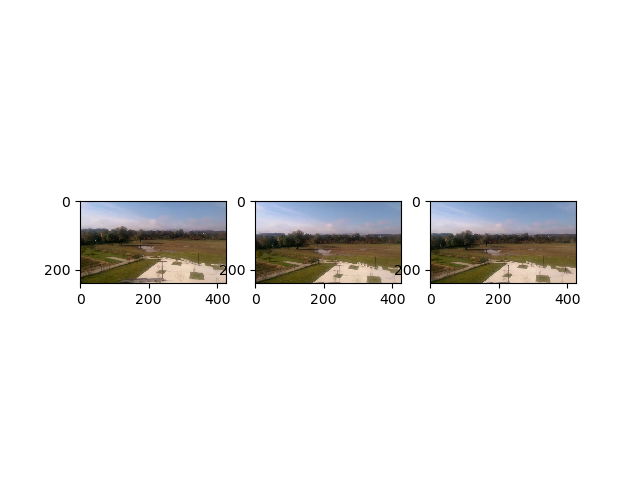

In [20]:
import skvideo.io
import numpy as np
from matplotlib import pyplot as plt

videodata = skvideo.io.vread("shaky.mp4")

print(videodata.shape) # The video matrix is N x H x W x C (N = number of frames)

image = np.squeeze(videodata[1, :, :, :]) # To visualize a single frame, we have to remove the singleton dimension

plt.figure()
plt.subplot(131)
plt.imshow(image) 
plt.show() # Display the image

# TODO: 
# visualize frames 100 and 150 next to the first frame
# use subplots
plt.subplot(132)
plt.imshow(np.squeeze(videodata[100, :, :, :]))
plt.subplot(133)
plt.imshow(np.squeeze(videodata[150, :, :, :]))
plt.show()

 * Write a function `track_point`, which, given the video data, coordinates of the initial point, size of the surrounding template patch, and the size of the search neighborhood, computes and returns the trajectory that corresponds to motion of the point throughout the whole video sequence. To find the best template match in subsequent frames, use the built-in function `skimage.feature.match_template` that calculates a normalized cross-correlation in 2D matrices.


In [ ]:
from skimage.feature import match_template
from skimage.color import rgb2gray

def track_point(video, x, y, patch_size = 10, search_size = 40):

    length, height, width, _ = video.shape

    frame = rgb2gray(np.squeeze(video[1, :, :, :])) # convert image to grayscale
    x1 = int(max(1, x - patch_size / 2))
    y1 = int(max(1, y - patch_size / 2))
    x2 = int(min(width, x + patch_size / 2 - 1))
    y2 = int(min(height, y + patch_size / 2 - 1))
    template = frame[y1:y2, x1:x2] # cut the reference patch (template) from the first frame
    
    th, tw = template.shape

    track_x = [x]
    track_y = [y]

    for i in range(1, length):
        frame = rgb2gray(np.squeeze(video[i, :, :, :])) # Extract current frame and convert it grayscale
        # TODO: cut-out a region of search_size x search_size from 'frame' with the center in the point's previous position (i-1)
        xL = int(max(1, track_x[i-1]-search_size/2))
        xR = int(min(width, track_x[i-1]+search_size/2))
        yU = int(max(1, track_y[i-1]-search_size/2))
        yD = int(min(height, track_y[i-1]+search_size/2))
        region = frame[yU:yD, xL:xR]
        
        result = match_template(frame, template, pad_input=False, mode='constant', constant_values=0) # Compare the region to template using match_template
        # TODO: select best match (maximum) and determine its position. Update x and y and append new x,y values to track_x,track_y
        ix = np.array(np.unravel_index(np.argmax(result), result.shape))
        
        track_x.append(int(ix[1]+tw/2))
        track_y.append(int(ix[0]+th/2))
        
    return track_x, track_y
        

 * Write a program that reads the video `shaky.mp4`, displays the first frame, and asks the user to pick the center point. Afterwards, use the previously-written function `track_point` to obtain the point's trajectory and display it over the last frame of the video sequence. Experimentally determine the template patch size and the search-neighborhood size that result in stable tracking of the point.


<IPython.core.display.Javascript object>


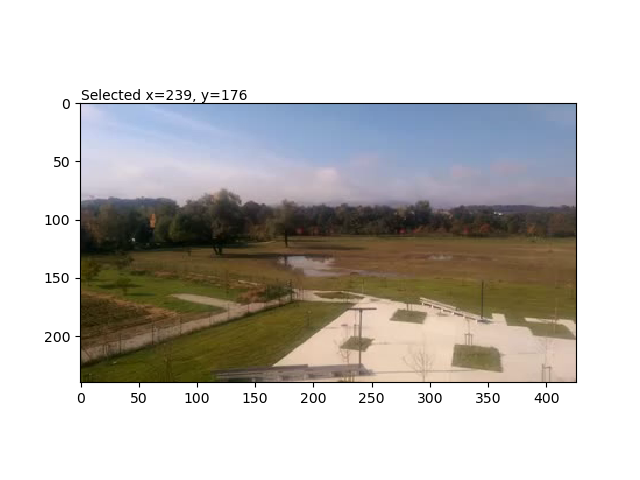

In [45]:
import skvideo.io
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Cursor

video = skvideo.io.vread("shaky.mp4")
image = np.squeeze(video[1, :, :, :]) 

point = (0, 0)

def point_selected(event):
    global point
    tx = 'Selected x=%d, y=%d' % (event.xdata, event.ydata)
    text.set_text(tx)
    point = (event.xdata, event.ydata)

figure = plt.figure()
plt.gca().imshow(image) 
text=plt.gca().text(0,0, "", va="bottom", ha="left")

cursor = Cursor(plt.gca(), useblit=True, color='red', linewidth=2)

figure.canvas.mpl_connect('button_press_event', point_selected)
plt.show()

<IPython.core.display.Javascript object>


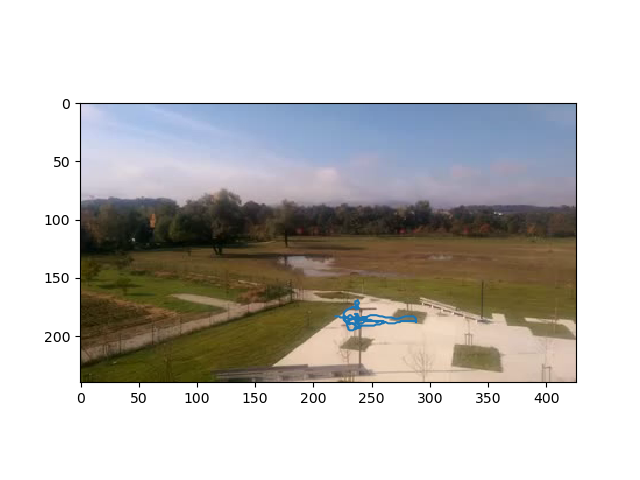

In [46]:
# TODO: Use track_point function to obtain the selected point's trajectory...
X,Y = track_point(video, int(point[0]), int(point[1]))
# Draw trajectory on top of the first frame from video...
image = np.squeeze(video[1, :, :, :]) 
figure = plt.figure()
plt.gca().imshow(image) 
plt.gca().plot(X, Y) 


 * Write a program in which you make use of the trajectory, obtained by `track_point`. The program should create a new video sequence, in which the original images are translated by offsets that correspond to negative estimated motion vectors. In other words, for each frame from original video, create an image of same size, and copy the original pixel elements with an offset that you obtain from the computed trajectory. If no pixel from the source image maps to a pixel in the destination image, that pixel should be left black. You can use function and classes in `skimage.transform` to implement transformation (note that the `warp` function will convert image to float by default, use `preserve_range` parameter to avoid it). Write the video sequence to disk frame by frame using function `skvideo.io.vwrite` (unfortunatelly the function tends to exit before the video is fully written so you may get errors when trying to play it too soon) If you want to play the video in browser you have to use H.264 encoding: `vwrite(file, data, outputdict={'-vcodec': 'libx264'})`.

In [47]:
from skimage.transform import EuclideanTransform, warp

outvideo = np.ndarray(video.shape, dtype=np.uint8)

for i in range(len(X)):
    # TODO: Estimate motion vectors dx and dy
    dx = X[0] - X[i]
    dy = Y[0] - Y[i]
    
    dx = -dx
    dy = -dy
    # Calculate Euclidean transformation based on motion vectors
    t = EuclideanTransform(translation=(dx, dy))
    frame = np.squeeze(video[i, :, :, :]) 
    frame = warp(frame, t, output_shape=(video.shape[1], video.shape[2]), preserve_range=True)

    outvideo[i, :, :, :] = frame
    


In [48]:
from skvideo.io import vwrite

# write stabilized video to disk
vwrite("shaky_stable.mp4", outvideo, outputdict={'-vcodec': 'libx264'})

# show stabilized video
from IPython.display import Video
Video("shaky_stable.mp4")


 * **(5 points)** Currently the stabilized video is filled with a lot of black area around the borders that is the result of the fact that we have to shift the images in order to compensate for the motion. But since the scene our test video is more or less stationary, at least some of the information about these regions can be recovered from the overall video. Implement and demonstrate an algorithm that fills these black pixels with information obtained from a mean image obtained by stabilizing the entire video and computing a mean over pixel values for all images (it is best to assign value ´NaN´ to all pixels that are not available in a certain stabilized image and then use function ´numpy.nanmean´ that filters out these values before it calculates mean so that these values do not influence the estimate, e.g. make the entire image darker).

In [53]:
# TODO 1: Compute mean background 'background'
# Hint: We can calculate mean value of Red channel without NAN values with np.nanmean(video[:,:,:,0], axis=0)
#       Do similar for other channels. Use np.stack((....), axis=0) to stack channels together...

r = np.nanmean(video[:,:,:,0], axis=0)
g = np.nanmean(video[:,:,:,1], axis=0)
b = np.nanmean(video[:,:,:,2], axis=0)
bg=np.stack((r,g,b), axis=2)

filled = np.empty(video.shape[1:4], dtype=np.uint8)
filled[:] = np.nan

outvideo_filled = np.ndarray(video.shape, dtype=np.uint8)

for i in range(video.shape[0]):
    # TODO 2: Estimate motion vectors dx, dy (same as in excercise above)
    dx = X[0] - X[i]
    dy = Y[0] - Y[i]
    
    dx=-dx
    dy=-dy
    
    # Calculate Euclidean transformation
    t = EuclideanTransform(translation=(dx, dy))
    # Get current frame...
    frame = np.squeeze(video[i, :, :, :])
    # ... and warp it/translate it based on calculated Euclidean transformation
    # Set cval=np.nan to fill black areas around the borders with NaN values...
    frame = warp(frame, t, output_shape=(video.shape[1], video.shape[2]), preserve_range=True, cval=np.nan)
    
    # TODO 3: Replace NaN values in 'frame' with pixels from the averaged background...
    frame[np.isnan(frame)] = bg[np.isnan(frame)]
    # Convert frame back to uint8 and add it to output video...
    frame = frame.astype(np.uint8)
    outvideo_filled[i, :, :, :] = frame
    
# Write video to disk
vwrite("shaky_filled.mp4", outvideo_filled, outputdict={'-vcodec': 'libx264'})

# Display video
from IPython.display import Video
Video("shaky_filled.mp4")




 * The kind of stabilization that we have obtained so far is not always desirable; depending on how unstable the source video is, we may end up discarding significant parts of images. In addition, completely static video sequences tend to look unnatural. As our main goal is compensation of sudden movements, we will upgrade our stabilization with smoothing. Modify the script from the previous step so that it will use function `smooth_trajectory` to smooth the trajectory before using it for stabilization. Save the resulting video file to `smooth.mp4`. Explain how function `smooth_trajectory` performs smoothing.

In [55]:
import numpy as np

# generate gaussian kernel (like "fspecial" in matlab)
def gauss_2d(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Smooth trajectory using gaussian kernel
def smooth_trajectory(track_x, track_y):
    s = 20 # kernel shape
    G = gauss_2d([s, 1], s / 6)
    G = np.reshape(G, len(G))
    
    # padding to get same results as we would using matlab "conv" function
    npad = len(G) - 1
    track_x_padded = np.pad(track_x, (npad // 2, npad - npad // 2), mode='constant')
    track_y_padded = np.pad(track_y, (npad // 2, npad - npad // 2), mode='constant')
    
    # smoothen movement in x-axis
    smooth_x = np.convolve(track_x_padded, G, 'valid')

    # smoothen movement in y-axis
    smooth_y = np.convolve(track_y_padded, G, 'valid')
    
    return smooth_x, smooth_y

# Perform smoothing of X and Y trajectories...
smoothed_x, smoothed_y = smooth_trajectory(X, Y)

# TODO: Use smoothen trajectories for video stabilization
#       Save the resulting video file to smooth.mp4
outvideo_smooth = np.ndarray(video.shape, dtype=np.uint8)
XS = smoothed_x
YS = smoothed_y
for i in range(video.shape[0]):
    # TODO 2: Estimate motion vectors dx, dy (same as in excercise above)
    dx = -(XS[0] - XS[i])
    dy = -(YS[0] - YS[i])
    # Calculate Euclidean transformation
    t = EuclideanTransform(translation=(dx, dy))
    # Get current frame...
    frame = np.squeeze(video[i, :, :, :])
    # ... and warp it/translate it based on calculated Euclidean transformation
    # Set cval=np.nan to fill black areas around the borders with NaN values...
    frame = warp(frame, t, output_shape=(video.shape[1], video.shape[2]), preserve_range=True, cval=np.nan)
    
    # TODO 3: Replace NaN values in 'frame' with pixels from the averaged background...
    frame[np.isnan(frame)] = background[np.isnan(frame)]
    # Convert frame back to uint8 and add it to output video...
    frame = frame.astype(np.uint8)
    outvideo_smooth[i, :, :, :] = frame
    
vwrite("smooth.mp4", outvideo_smooth, outputdict={'-vcodec': 'libx264'})

# Display video
from IPython.display import Video
Video("smooth.mp4")
    

 * **(10 points)** In a lot of cases tracking only a single point may not be desirable, the tracking can fail or can be unreliable. It is better to look at more points and calculate their consistency for each frame to estimate motion. Implement and demonstrate an algorithm that tracks more (three or more) points and at every frame selects the ones that are agreeing on translation of the image (point in the same direction) and computes their average estimate. Then render a stabilized video using these more robust estimates.

In [27]:
# TODO

 * **(10 points)** Sometimes, estimating only translation may not be enough to stabilize the video, you may also have to account for rotation. Actually the video can also contain other deformations, but for this task we will only focus on rotation. Use video stored in file `rotation.mp4` for this task and try to remove it. You will have to track more points and use them to estimate rotation from them. Hint: it is best to first complete other assignments in this exercise because there may be some valuable information there.

In [28]:
# TODO

Video centering
----

The goal of this assignment is to crop the input video sequence, centering it on the currently most salient (interesting) region. This *region of interest* will be determined by a simple mechanism of computing the difference of corresponding pixels in two consecutive frames. In order to avoid drifts due to illumination changes, we will look for the differences in the hue part of the HSV color space.

* Create a script that reads the video from file `bigbuck1.mp4`. Afterwards, it should iterate over the video, convert pairs of consecutive frames into HSV color space, extract their *hue* component, and compute the absolute differences of all value pairs. Display the result for several frame differences.

<IPython.core.display.Javascript object>


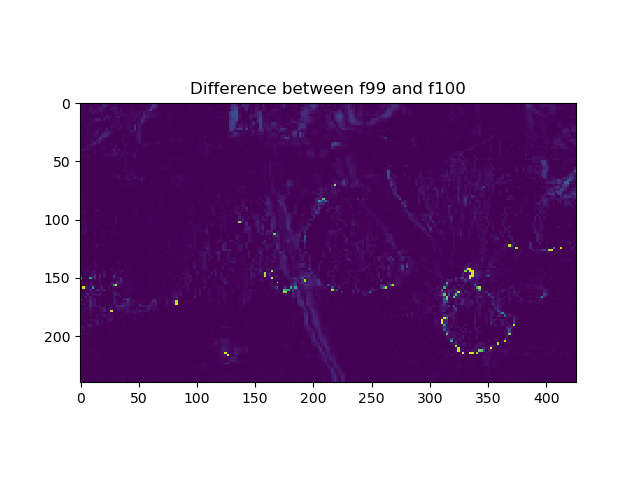

<IPython.core.display.Javascript object>


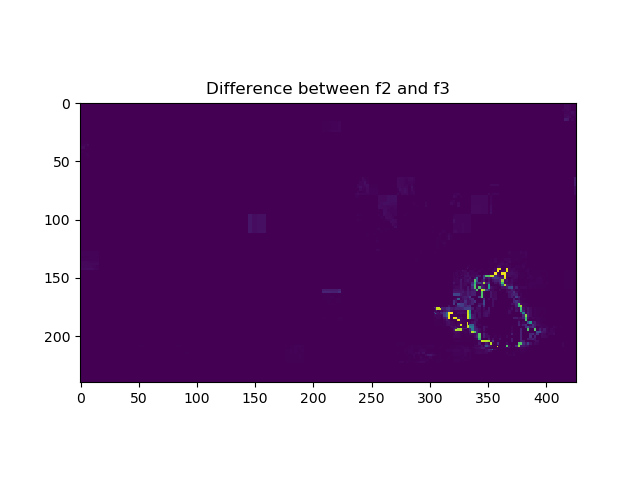

<IPython.core.display.Javascript object>


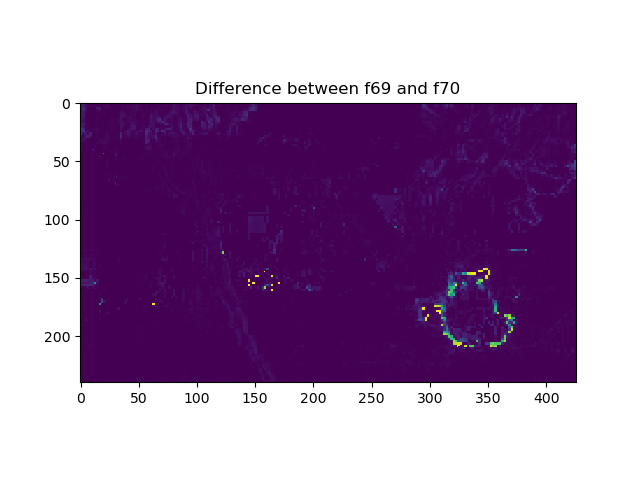

In [60]:
from skimage.color import rgb2hsv, hsv2rgb

# Read video
video_bigbuck = skvideo.io.vread("bigbuck1.mp4")
# Get the initial frame from the video
img_t0 = np.squeeze(video_bigbuck[0, :, :, :])
# Convert it to HSV colorspace
img_t0 = rgb2hsv(img_t0)

# Placeholder of absolute differences between consecutive frames...
abs_differences = np.ndarray(video_bigbuck.shape[0:3], dtype=np.float64)

for i in range(1, video_bigbuck.shape[0]):
    # TODO 1: Get current frame and convert it to HSV
    curr_frame = np.squeeze(video_bigbuck[i, :,:,:])
    curr_frame = rgb2hsv(curr_frame)
    # TODO 2: Compute the absolute difference ('abs_dif') in HUE component of two consecutive frames
    abs_dif = abs(img_t0[:,:,0] - curr_frame[:,:,0])
    # Add computed difference to the list...
    abs_differences[i, :, :] = abs_dif
    
    # TODO 3: Update t0 image
    img_t0 = curr_frame

# Visualize absolute difference in HUE component between frames 99 and 100
plt.figure()
plt.clf()
plt.imshow(abs_differences[100, :, :])
plt.title("Difference between f99 and f100")
plt.figure()
plt.clf()
plt.imshow(abs_differences[3, :, :])
plt.title("Difference between f2 and f3")
plt.figure()
plt.clf()
plt.imshow(abs_differences[70, :, :])
plt.title("Difference between f69 and f70")
plt.show()

from IPython.display import Video
Video("bigbuck1.mp4")
    
    

 * Create a script that iterates over the video and smooths the absolute differences with the built-in <i>rank.mean</i> function.

<IPython.core.display.Javascript object>


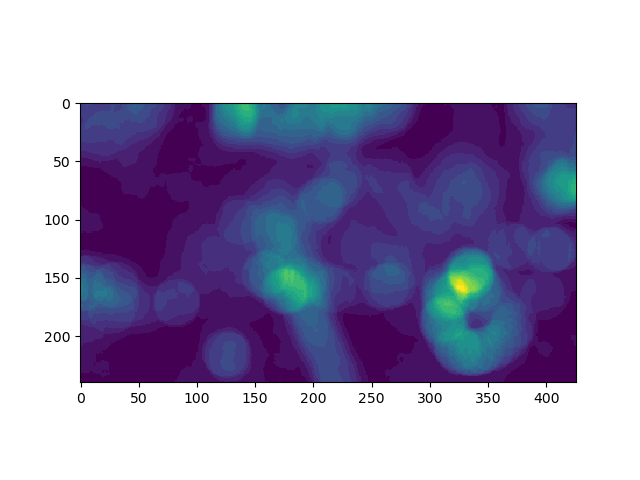

In [62]:
from skimage.color import rgb2hsv, hsv2rgb
from skimage.morphology import disk
from skimage.filters import rank

# Load bigbuck video
video_bigbuck = skvideo.io.vread("bigbuck1.mp4")
# Get the initial frame from the video
img_t0 = np.squeeze(video_bigbuck[0, :, :, :])
# Convert it to HSV colorspace
img_t0 = rgb2hsv(img_t0)

# Difine filter for smoothening
# In this example we will use "disk"
# This will generate a disk filter with radious 20 pixels.
# In order to obtain good results, you will need to experiment
#   with different filters and different values
avg_filter = disk(20)

# Placeholder of smoothen absolute differences masks between consecutive frames...
abs_differences_smooth = np.ndarray(video_bigbuck.shape[0:3], dtype=np.float64)

for i in range(1, video_bigbuck.shape[0]):
    # TODO 1: Get current frame and convert it to HSV
    f = np.squeeze(video_bigbuck[i, :, :, :])
    f = rgb2hsv(f)
    # TODO 2: Compute the absolute difference ('abs_dif') in HUE component of two consecutive frames
    abs_dif = abs(img_t0[:,:,0] - f[:,:,0])
    # use rank.mean to smoothen the absolute differences 'abs_dif'...
    abs_dif_smooth = rank.mean(abs_dif, selem=avg_filter)
    
    # Add computed difference to the list...
    abs_differences_smooth[i, :, :] = abs_dif_smooth
    
    # TODO 3: Update t0 image
    img_t0 = f

# Visualize smoothed absolute difference in HUE component between frames 99 and 100
plt.figure()
plt.clf()
plt.imshow(abs_differences_smooth[100, :, :])
plt.show()


 * In each smoothed absolute difference of *hue* components for two consecutive frames, determine the point with the largest difference value. Store the corresponding coordinates in two vectors, which determine the trajectory. Experiment with different kernel size (in the snippet above, it was set to 150), and determine the value for which the obtained trajectory most closely follows the happening in the video.
 
   Question: Why is it a good idea to smooth the response before trying to find the maximum? Try finding the maximum both with and without smoothing, and write down your explanation on why smoothing is useful.

In [63]:
"""
A moving object may "obstruct" differences between frames, causing greater differences betwen frames,
which we may "find" as a maximum. By smoothing, we average this difference, taking a more accurate maximum.

In addition, compression may leave artefacts in our video (which aren't "a part" of said video).
These artefacts could cause a greater difference between frames, smoothing helps with getting rid of said artefacts.
"""

'\nA moving object may "obstruct" differences between frames, causing greater differences betwen frames,\nwhich we may "find" as a maximum. By smoothing, we average this difference, taking a more accurate maximum.\n\nIn addition, compression may leave artefacts in our video (which aren\'t "a part" of said video).\nThese artefacts could cause a greater difference between frames, smoothing helps with getting rid of said artefacts.\n'

 * Write a new script that makes use of the obtained trajectory; it should crop each frame to a fixed-size window of 100 pixels, centered around the current point on the trajectory. Store the resulting sequence and convert it to a video file and bring it with you to the presentation of the exercise. Be careful when the selected object is near the edge of the image. In such a case, you need to make sure that you do not go with the template over the edge of the image.

In [72]:
# Load bigbuck video
video_bigbuck = skvideo.io.vread("bigbuck1.mp4")
# Get the initial frame from the video
img_t0 = np.squeeze(video_bigbuck[0, :, :, :])
# Convert it to HSV colorspace
img_t0 = rgb2hsv(img_t0)

h = video_bigbuck.shape[1]
w = video_bigbuck.shape[2]
# Difine filter for smoothening
# In this example we will use "disk"
# This will generate a disk filter with radious 20 pixels.
# In order to obtain good results, you will need to experiment
#   with different filters and different values
avg_filter = disk(20)

# Placeholder of centered image size 100x100...
outvideo_centered = np.ndarray([video_bigbuck.shape[0], 100, 100, 3], dtype=np.uint8)

global x_trajectory
global y_trajectory

x_trajectory = []
y_trajectory = []

for i in range(1, video_bigbuck.shape[0]):
    # TODO 1: Get current frame and convert it to HSV
    f = np.squeeze(video_bigbuck[i, :, :, :])
    hsv_f = rgb2hsv(f)
    # TODO 2: Compute the absolute difference ('abs_dif') in HUE component of two consecutive frames
    abs_dif = abs(img_t0[:,:,0] - hsv_f[:,:,0])
    # Use rank.mean to smoothen the absolute differences 'abs_dif'...
    abs_dif_smooth = rank.mean(abs_dif, selem=avg_filter)
    # Get indices of maximum absolute difference between two consecutive frames
    #  max_ind[0] - y index, where maximum difference between two consecutive frames is reached
    #  max_ind[1] - x index, where maximum difference between two consecutive frames is reached
    max_ind = np.array(np.unravel_index(np.argmax(abs_dif_smooth, axis=None), abs_dif_smooth.shape))
    
    y_trajectory.append(max_ind[0])
    x_trajectory.append(max_ind[1])
    
    # TODO 3: Get 100x100 region, centered at (max_ind[1],max_ind[0]), from the current frame
    res = np.zeros([100, 100, 3])
    region = f[max((max_ind[0]-50), 1):min((max_ind[0]+50),h), max((max_ind[1]-50), 1):min((max_ind[1]+50), w), :]
    res[:region.shape[0], :region.shape[1], :region.shape[2]] = region
    # Add extracted region to the output video...
    outvideo_centered[i, :, :, :] = res
    
    # TODO 3: Update t0 image
    img_t0 = hsv_f

# Save and display the video
vwrite("buck_centered.mp4", outvideo_centered, outputdict={'-vcodec': 'libx264'})
Video("buck_centered.mp4")



 *  Use the function ´smooth_trajectory´ to smooth the trajectory and improve the results qualitatively, and repeat the video cropping procedure.

In [74]:
# TODO 1: Add the following two vectors to the previous code:

# TODO 2: loop throught the video and save x and y index of the maximum value to x_trajectory and y_trajectory
#         Do not execute the cropping procedure at this step

# TODO 3: Once finished, use function 'smooth_trajectory' on x_trajectory and y_trajectory to smoothen the trajectories.
xts, yts = smooth = smooth_trajectory(x_trajectory, y_trajectory)
# TODO 4: Use smoothen trajectories and repeat the video cropping procedure to improve the results qualitatively.
outvideo_centered_smooth = np.ndarray([video_bigbuck.shape[0], 100, 100, 3], dtype=np.uint8)

h = video_bigbuck.shape[1]
w = video_bigbuck.shape[2]

for i in range(video_bigbuck.shape[0]-1):
    f = np.squeeze(video_bigbuck[i,:,:,:])
    res = np.zeros([100, 100, 3])
    region = f[max((int(yts[i])-50), 1):min((int(yts[i])+50),h), max((int(xts[i])-50), 1):min((int(xts[i])+50), w), :]
    res[:region.shape[0],:region.shape[1],:region.shape[2]] = region
    outvideo_centered_smooth[i,:,:,:] = res;

# Save and display the video
vwrite("buck_centered_smooth.mp4", outvideo_centered_smooth, outputdict={'-vcodec': 'libx264'})
Video("buck_centered_smooth.mp4")


 * **(5 points)** Improve the change detection procedure with an idea of your own. You can increase the robustness by combining multiple visual cues (e.g. changes in different color spaces and channels) or enforcing constraints on movement between consecutive frames. Your algorithm should noticeably improve the performance of the baseline method on the test video, but you can also demonstrate its behavior on some other video of your own. Convert the resulting sequence to a video file and bring it with you to the presentation of the exercise.

In [ ]:
# TODO

Detection of shot transitions
----

Sudden changes in shots can be detected by observing the differences between two consecutive images in the video sequence. If the difference is small, it can most likely be attributed to changes within the shot; if the difference is large, it is most likely due to the transition between two shots. You will implement a simple detector of shot transitions based on histogram comparison. Note that this is a very simple algorithm, and if you wanted to use it in real-life applications, you would likely need to combine it with other modalities.

To compute the distance between two histograms you will use Hellinger distance that is defined as:

\begin{equation}
H(\mathbf{h}_1,\mathbf{h}_2) = \sqrt{  \frac{1}{2} \sum_{i=0}^{N-1} \Big( \sqrt{h_1(i)} - \sqrt{h_2(i)} \Big)^2 }.
\end{equation}

Note that low values of Hellinger distances signify high similarity and high values signify low similarity.


 * Load the video sequence `bigbuck2.mp4` into the memory. For each image in the video sequence, compute separate histograms for red, green, and blue channel, and then concatenate them into a single vector. Start with 8-bin histograms, and later experiment with different number of bins. Use *Hellinger distance* to compute similarities between histograms of consecutive image pairs. Store the results for the entire sequence to a vector, and visualize them using the `matplotlib.pyplot.plot` function.

<IPython.core.display.Javascript object>


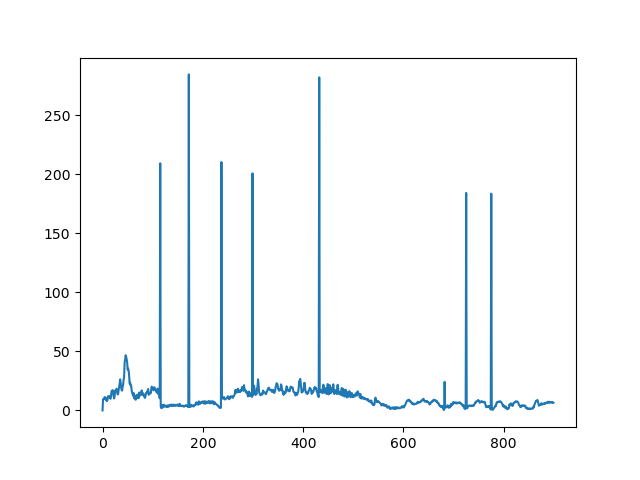

In [75]:
from skimage.exposure import histogram

def hellinger_distance(h1, h2):
    h1_sqrt = np.sqrt(h1) # Compute square root of all elements from h1
    h2_sqrt = np.sqrt(h2) # Compute square root of all elements from h2
    squared_dif = (h1_sqrt - h2_sqrt) ** 2 # Compute squared difference of h1_sqrt and h2_sqrt
    return np.sqrt( (sum(squared_dif)) / 2 ) # return hellinger distance...
    
# Load bigbuck video
video_bigbuck = skvideo.io.vread("bigbuck2.mp4")
# TODO 1: Extract histograms for each R, G, B channel of initial image
r_hvalues_0, rhbins = histogram(video_bigbuck[0,:,:,0], nbins=8, source_range='dtype', normalize=False)
g_hvalues_0, ghbins = histogram(video_bigbuck[0,:,:,1], nbins=8, source_range='dtype', normalize=False)
b_hvalues_0, bhbins = histogram(video_bigbuck[0,:,:,2], nbins=8, source_range='dtype', normalize=False)

# Concatenate histograms for R (r_hvalues_0), G (g_hvalues_0) and B (b_hvalues_0) channel into a single vector 'hist_0'
hist_0 = np.concatenate((r_hvalues_0, g_hvalues_0, b_hvalues_0), axis=None)

# Placeholder for Hellinger Distances
# Here we will store frame number and Hellinger distance computed for this frame
hellinger_distances = np.ndarray([video_bigbuck.shape[0], 2], dtype=np.float64)

for i in range(1, video_bigbuck.shape[0]):
    # TODO 1: Extract histograms for each R, G, B channel of current image
    r_hvalues_1, rhbins = histogram(video_bigbuck[i,:,:,0], nbins=8, source_range='dtype', normalize=False)
    g_hvalues_1, ghbins = histogram(video_bigbuck[i,:,:,1], nbins=8, source_range='dtype', normalize=False)
    b_hvalues_1, bhbins = histogram(video_bigbuck[i,:,:,2], nbins=8, source_range='dtype', normalize=False)
    # Concatenate histograms for R (r_hvalues_1), G (g_hvalues_1) and B (b_hvalues_1) channel into a single vector 'hist_1'
    hist_1 = np.concatenate((r_hvalues_1, g_hvalues_1, b_hvalues_1), axis=None)
    
    # TODO 2: Calculate Hellinger distances and update the list of hellinger distances...
    d = hellinger_distance(hist_0, hist_1)
    hellinger_distances[i] = [i, d]
    # TODO 3: Update hist_0
    hist_0 = hist_1
    
# Visualize the results
plt.figure()
plt.clf()
# hellinger_distances[:,0] corresponds to frame number (plotted on x-axis)
# hellinger_distances[:,1] corresponds to Hellinger distance (plotted on y-axis)
plt.plot(hellinger_distances[:,0], hellinger_distances[:,1])


 * Based on the obtained inter-frame histogram distances, estimate a threshold that will allow you to detect shot transitions. A straightforward automatic way of determining this threshold is to set the threshold to a certain portion (e.g., 20%) of the maximum value. This approach has several limitations (can you think of some?), but illustrates the general idea. Using the estimated threshold value, determine the positions of shot transitions, and visualize them by displaying five consecutive frames around each transition. Display all transitions in rows of a single figure, with each row corresponding to a single transition.

<IPython.core.display.Javascript object>


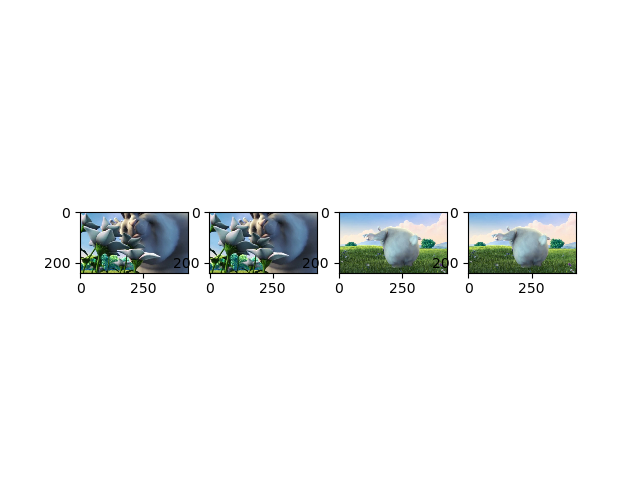

<IPython.core.display.Javascript object>


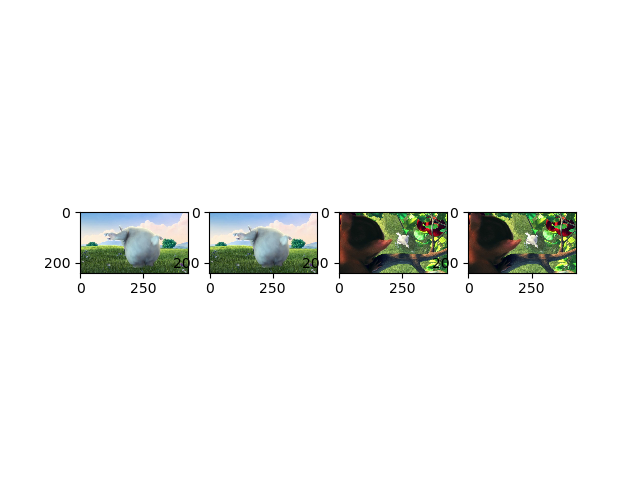

<IPython.core.display.Javascript object>


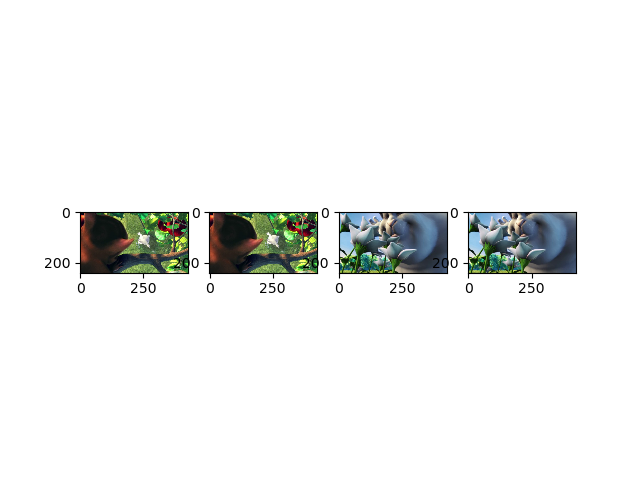

<IPython.core.display.Javascript object>


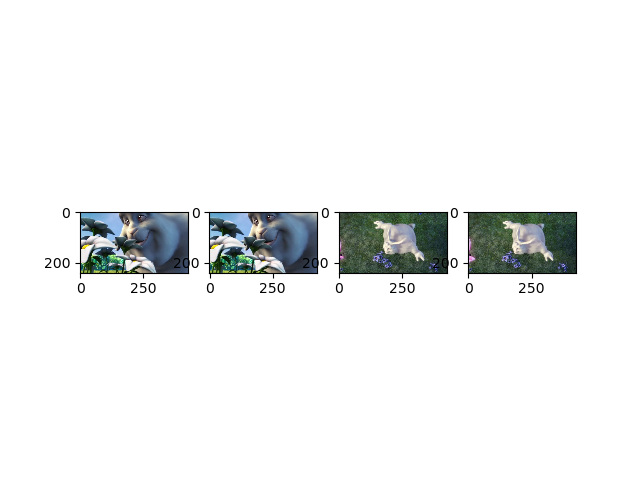

<IPython.core.display.Javascript object>


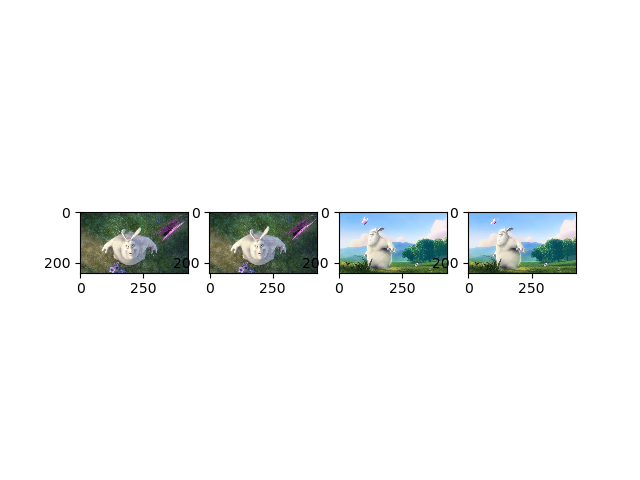

<IPython.core.display.Javascript object>


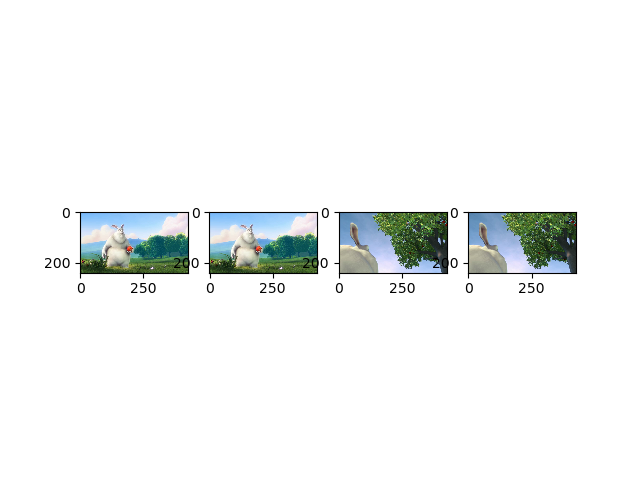

<IPython.core.display.Javascript object>


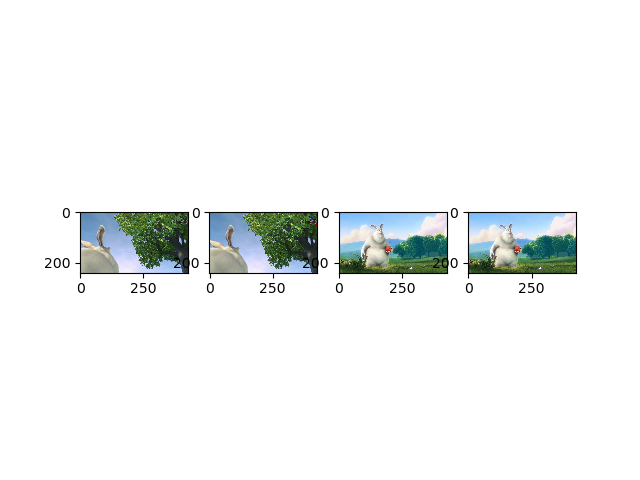

In [76]:
# TODO
dif = np.transpose(hellinger_distances)[1]
threshold = int(max(dif)*0.2)

for i in range(len(dif)):
    if dif[i] > threshold:
        plt.figure()
        for j in range(4):
            plt.subplot(1, 4, j+1)
            plt.imshow(np.squeeze(video_bigbuck[i-2+j, :, :, :]))
            
plt.show()

* (**10 points)** Replace the global threshold with a more robust alternative. The actual implementation is left to you, however, here are some hints: you can implement non-maxima suppression to eliminate double peaks, and use median filter to obtain a dynamic threshold. To complete this task, you have to test your method on another video sequence with multiple shots (not part of the material) and demonstrate that your proposed method can detect at least some of the transitions that the baseline method fails to detect. Note that you do not need to load the entire video at once; you can load and process two consecutive images at a time to avoid running into memory or storage issues.

In [ ]:
# TODO